# Marketing Case

The Marketing team has collected some data from previous marketing campaign. The data set includes customer information, described below, as a well as whether the customer responded to the marketing campaign or not.

## Data

 Here is the description of each column in the data set:
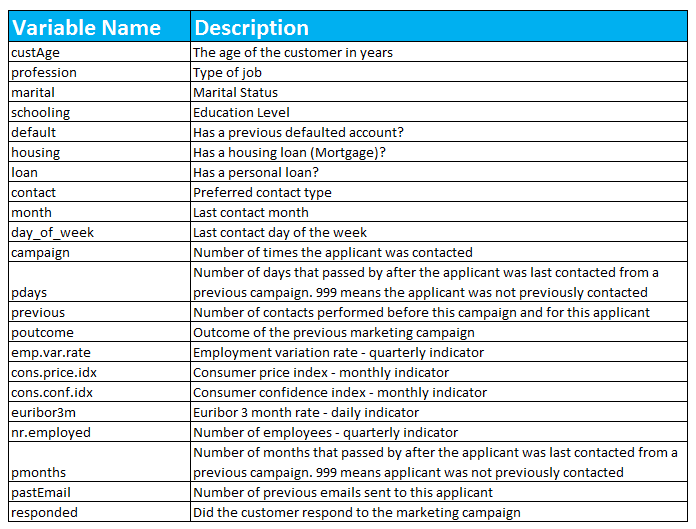
 

## Process

In order to develop the solution we will focus in the following steps which will be covered in theit own notebook

1.Marketing_Case-ELVT-Clean
- Getting the Data
- Explore the Data
- Pre-process and clean the data

2 .Marketing_Case-ELVT-Build
- Build the model

3 .Marketing_Case-ELVT-Deploy
- Deploy 


### Install required modules

In [1]:
# #uncomment for pandas_profiling
# import sys
# !{sys.executable} -m pip install pandas_profiling #https://github.com/pandas-profiling/pandas-profiling

# #uncomment for h2o
# pip install requests
# pip install tabulate
# pip install scikit-learn
# pip uninstall h2o
# pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o --user

## Getting the Data

In [24]:
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas_profiling
import seaborn as sns
import numpy as np
from collections import Counter

In [3]:
#data and problem statment is from https://github.com/josuersd19/ELVT_CaseBInterview

file_cleaned = 'marketing_training_cleaned.csv'
url = 'https://raw.githubusercontent.com/giorgiosaez/data-science-cases/master/Marketing-EVT/marketing_training.csv'
data = pd.read_csv(url)

# Names & Number of rows and columns
print('Number or rows:', data.shape[0])
print('Number or columns:', data.shape[1])
#print('Columns Names:       Type')
#display(data.dtypes)

#print 8 rows of the first 11 variables 
display(data[data.columns[:11]].head(4))
display(data[data.columns[:11]].tail(4))
#print 8 rows of the last 11 variables 
display(data[data.columns[11:]].head(4))
display(data[data.columns[11:]].tail(4))

Number or rows: 7414
Number or columns: 22


,custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,campaign
0,55.0,admin.,single,university.degree,unknown,no,no,cellular,nov,mon,1
1,NaN,blue-collar,married,NaN,no,no,no,cellular,jul,mon,1
2,42.0,technician,married,high.school,no,no,no,telephone,may,mon,1
3,55.0,management,divorced,NaN,unknown,yes,yes,cellular,jul,wed,2


,custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,campaign
7410,45.0,blue-collar,married,basic.4y,unknown,no,no,telephone,jul,tue,3
7411,27.0,blue-collar,single,NaN,no,no,no,cellular,may,fri,2
7412,51.0,unemployed,divorced,high.school,unknown,yes,no,cellular,nov,thu,2
7413,38.0,blue-collar,married,high.school,no,yes,no,telephone,may,fri,1


,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,responded
0,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,999.0,0,no
1,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,999.0,0,no
2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,999.0,0,no
3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,999.0,0,no


,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,responded
7410,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,999.0,0,no
7411,999,1,failure,-1.8,92.893,-46.2,1.250,5099.1,999.0,3,no
7412,999,0,nonexistent,-0.1,93.200,-42.0,4.076,5195.8,999.0,0,no
7413,999,0,nonexistent,1.1,93.994,-36.4,4.864,5191.0,999.0,0,no


#### Utility functions

In [4]:
def plot_histogram(df, targetColumn, withValues = True):
    _vertical = False
    _bins = range(0, 10, 1)
    distinct = set(df)

    if withValues:
        print(df.name, sorted(distinct))
        
    if data.contact.dtype=='O' or len(distinct)<8:
        _bins=len(distinct)*2 
        
    sns.distplot(df.loc[targetColumn == 'no'], kde=False, color= 'r', label = 'No', bins=_bins)
    sns.distplot(df.loc[targetColumn == 'yes'], kde=False, color= 'b', label = 'Yes', bins=_bins)
    
    plt.legend()
    plt.show()

def get_outliers_bounds(df):
    Q1 = df.quantile(.25)
    Q3 = df.quantile(.75)
    
    IQR = Q3 - Q1
    
    return [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR] 


## Explore the data

Before we start, we will get a quick snapshot of the dataset with the help of <b>pandas_profiling</b> a module that gives much more information than pandas' describe(). 
It provides Quantile Statistics, Descriptive statistics, most frequent values, histograms, correlations and more.

In [5]:
# data.isnull().sum()
#Quick snapshop
print('Computing profiling report')
pfr = pandas_profiling.ProfileReport(data, correlation_overrides =['pmonths'])
pfr.to_file('ProfileReport.html')
display(pfr)

# re-adjusting size for plots (pandas_profiling changes it)
sns.set(rc={'figure.figsize':(15,4)})

Computing profiling report


Number of variables,22
Number of observations,7414
Total Missing (%),2.9%
Total size in memory,1.2 MiB
Average record size in memory,176.0 B
Numeric,9
Categorical,11
Boolean,0
Date,0
Text (Unique),0
Rejected,2


There is a lot of information in this report, so first, we will review it and then we will take actions from there.
- Number of variables	22
- Number of observations	7414

O = outliers, M = Missing, C = Categorical, D = Dirty, N = Normalize, T = Transform 

    campaign O C T
    cons.conf.idx & cons.price.idx N T
    contact C
    custAge O M has 1804 / 24.3% missing values
    day_of_week M C has 711 / 9.6% missing values 
    default C D
    emp.var.rate, euribor3m, nr.employed
    housing, loan, marital, Month
    pastEmail O has 6495 / 87.6% zeros
    pdays, pmonths 999? rest under 1 month
    poutcome 6350 and pdays has 7123?
    previous leave as is, has 6350 / 85.6% zeros
    profession C
    responded Target 88.7/11.3
    schooling C D change missing to unknown has 2155 / 29.1% missing values 

    euribor3m is highly correlated with emp.var.rate (ρ = 0.97095) and was Rejected
    nr.employed is highly correlated with euribor3m (ρ = 0.94255) and was Rejected
    pmonths is highly correlated with pdays (ρ = 0.99999) and was Rejected

    Dataset has 26 duplicate rows 

## Pre-process and clean the data

In the build a model notebook we will use H2Os GLM and GBM models and we will let H2O handle the categorical columns, as it can take advantage of the categorical column for better performance and memory utilization.

Due to this we will only clean data and we will not do any one-hot encoding

Now, we will use the previous information to tackle each column in the dataset. We will follow a simple guide to make sure we apply some initial analisis depending on first impresion 
     - O = outliers, M = Missing, C = Categorical, D = Dirty, N = Normalize, T = Transform

In [6]:
#Sorting to keep the same order as profiling 
data = data[sorted(data.columns)]
print(data.columns.values)

['campaign' 'cons.conf.idx' 'cons.price.idx' 'contact' 'custAge'
 'day_of_week' 'default' 'emp.var.rate' 'euribor3m' 'housing' 'loan'
 'marital' 'month' 'nr.employed' 'pastEmail' 'pdays' 'pmonths' 'poutcome'
 'previous' 'profession' 'responded' 'schooling']


### campaign

,count,mean,std,min,25%,50%,75%,max
campaign,7414.0,2.518344,2.695055,1.0,1.0,2.0,3.0,40.0


campaign [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 26, 27, 29, 30, 31, 33, 34, 35, 39, 40]


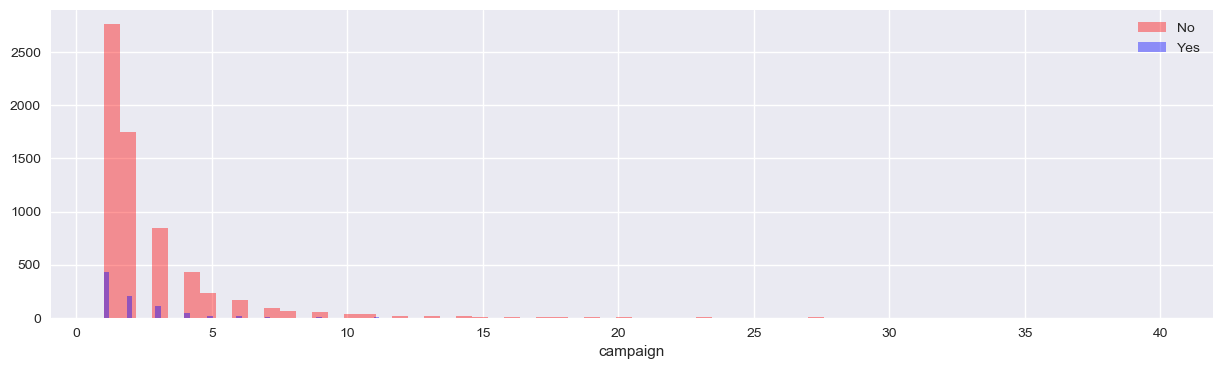

'Finding outliers'

Outliers bounds: [-2.0, 6.0]


'New feature'

Rename all campaings higher than: 6.0 as 7+
campaign1 ['1', '2', '3', '4', '5', '6', '7+']


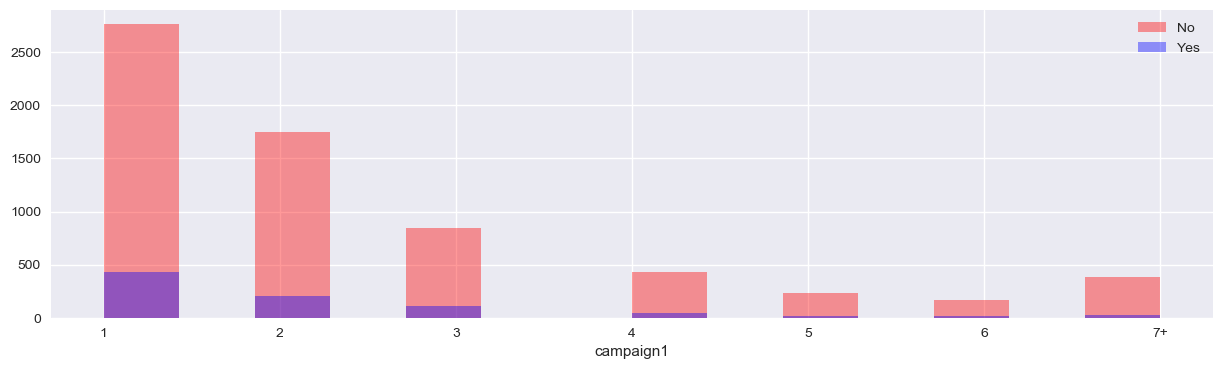

,count,unique,top,freq,1,2,5,3,6,4,7+
campaign1,7414,7,1,3193,3193,1953,245,956,179,477,411


In [7]:
#campaign O C T

dataColumn = 'campaign'

display(pd.DataFrame(data[dataColumn].describe()).T)

plot_histogram(data[dataColumn], data.responded)

#outliers
display('Finding outliers')
outliers = get_outliers_bounds(data[dataColumn])
print('Outliers bounds:', outliers)

display('New feature')
print('Rename all campaings higher than:',outliers[1], 'as 7+')
dataColumn = 'campaign1'
data[dataColumn] = data.campaign
data[dataColumn][data[dataColumn] > outliers[1]] = '7+'
data[dataColumn] = data[dataColumn].astype(str)

plot_histogram(data[dataColumn], data.responded)

counted = pd.DataFrame.from_dict(Counter(data[dataColumn]),orient='index')
counted.columns = [dataColumn]
display(pd.DataFrame(data[dataColumn].describe()).append(counted).T)



### cons.conf.idx

,count,mean,std,min,25%,50%,75%,max
cons.conf.idx,7414.0,-40.561316,4.6498,-50.8,-42.7,-41.8,-36.4,-26.9


cons.conf.idx ['-50.80', '-50.00', '-49.50', '-47.10', '-46.20', '-45.90', '-42.70', '-42.00', '-41.80', '-40.80', '-40.40', '-40.30', '-40.00', '-39.80', '-38.30', '-37.50', '-36.40', '-36.10', '-34.80', '-34.60', '-33.60', '-33.00', '-31.40', '-30.10', '-29.80', '-26.90']


'Finding outliers'

Outliers bounds: [-52.150000000000006, -26.949999999999992]


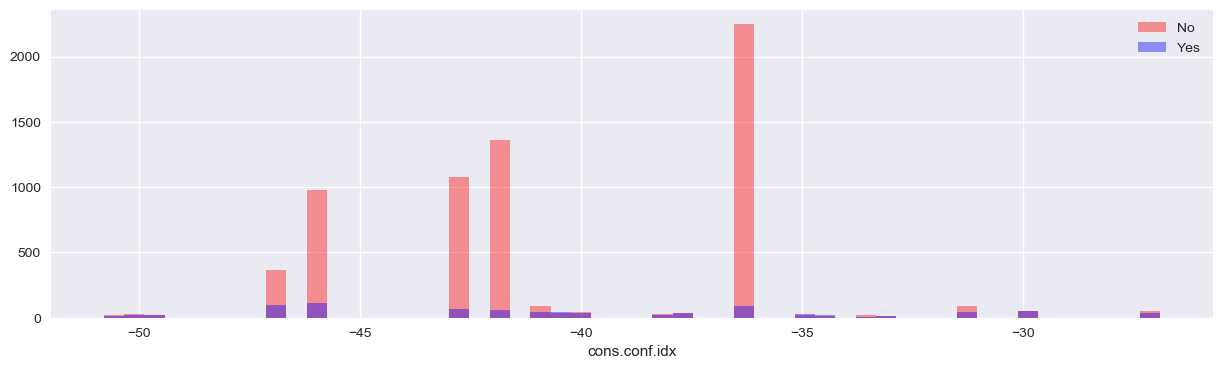

In [8]:
dataColumn = 'cons.conf.idx'

display(pd.DataFrame(data[dataColumn].describe()).T)
print(data[dataColumn].name,  ["%.2f"%item for item in sorted(set(data[dataColumn]))])

#outliers
display('Finding outliers')
outliers_bounds = get_outliers_bounds(data[dataColumn])
print('Outliers bounds:', outliers_bounds)

plot_histogram(data[dataColumn], data.responded, False)

### cons.price.idx

,count,mean,std,min,25%,50%,75%,max
cons.price.idx,7414.0,93.570708,0.578345,92.201,93.075,93.444,93.994,94.767


cons.price.idx ['92.20', '92.38', '92.43', '92.47', '92.65', '92.71', '92.76', '92.84', '92.89', '92.96', '93.08', '93.20', '93.37', '93.44', '93.75', '93.80', '93.88', '93.92', '93.99', '94.03', '94.06', '94.20', '94.22', '94.47', '94.60', '94.77']


'Finding outliers'

Outliers bounds: [91.69650000000001, 95.3725]


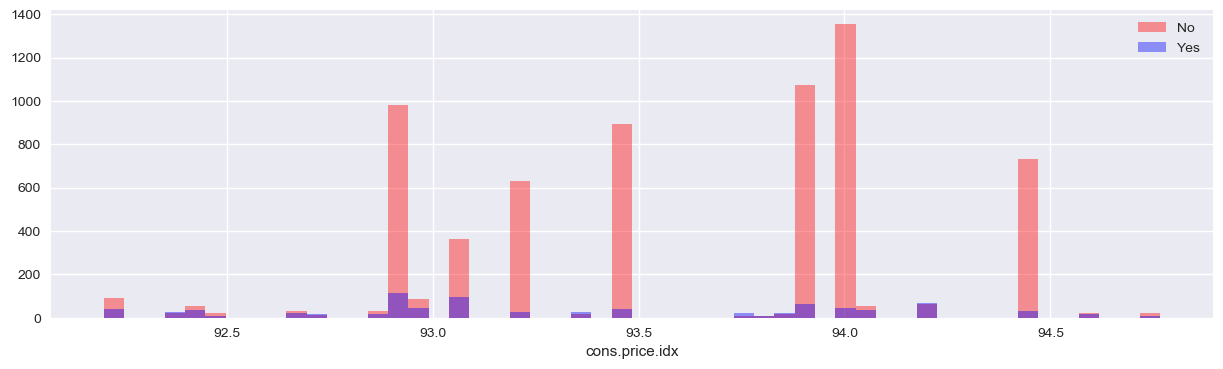

In [9]:
dataColumn = 'cons.price.idx'

display(pd.DataFrame(data[dataColumn].describe()).T)
print(data[dataColumn].name,  ["%.2f"%item for item in sorted(set(data[dataColumn]))])
#outliers
display('Finding outliers')
outliers_bounds = get_outliers_bounds(data[dataColumn])
print('Outliers bounds:', outliers_bounds)

plot_histogram(data[dataColumn], data.responded, False)

### contact

contact ['cellular', 'telephone']


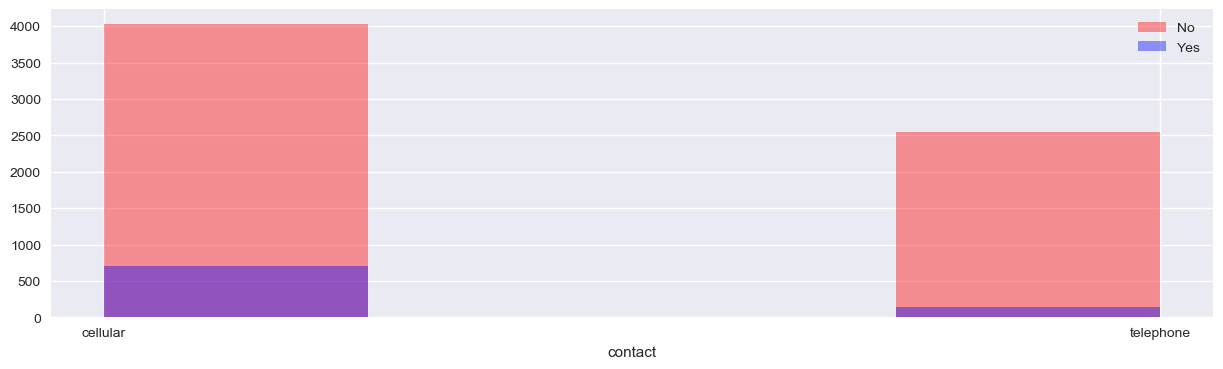

In [10]:
#contact C

dataColumn = 'contact'
pd.DataFrame(data[dataColumn].describe()).T

plot_histogram(data[dataColumn], data.responded)

### custAge

'Fill NaNs with mean by marital status'

custAge Mean: 40


marital,divorced,married,single,unknown
custAge,45.0,42.0,33.0,41.0


'Check outliers'

Outliers bounds: [15.0, 63.0]
Rename all ages higher than 63.0 as 64


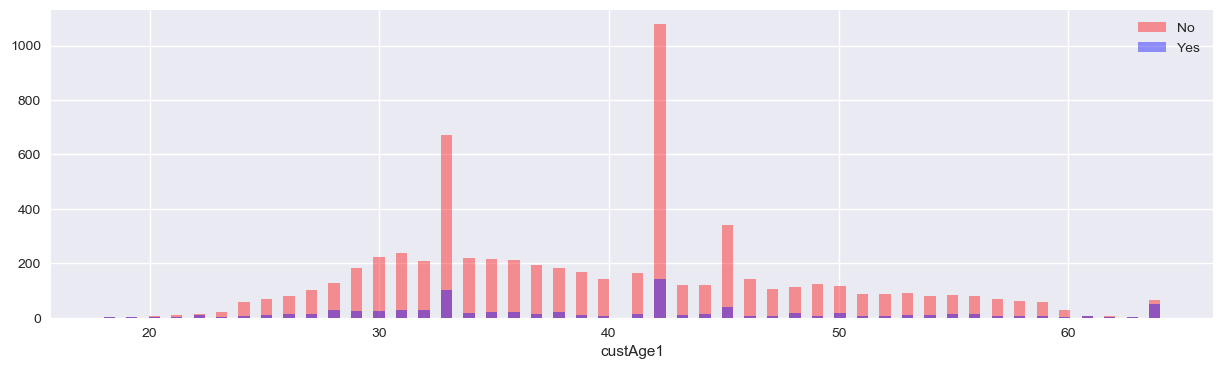

,count,mean,std,min,25%,50%,75%,max
custAge1,7414.0,39.790801,8.922048,18.0,33.0,40.0,45.0,64.0


In [11]:
#custAge O M has 1804 / 24.3% missing values
dataColumn = 'custAge'

display('Fill NaNs with mean by marital status')
#to input the age of the customers we will fill the missing information with the mean of marital status groups
data[dataColumn] = data.groupby(['marital']).transform(
    lambda x: x.fillna(round(x.mean())))[dataColumn]

print('custAge Mean:',round(data.custAge.mean()))
display(round(data[['custAge','profession','marital','schooling']].groupby('marital').mean()).T)

#outliers
display('Check outliers')
outliers_bounds = get_outliers_bounds(data[dataColumn])
print('Outliers bounds:', outliers_bounds)

print('Rename all ages higher than',outliers_bounds[1], 'as 64')

dataColumn = 'custAge1'

data[dataColumn] = data.custAge

data[dataColumn][data[dataColumn] > outliers_bounds[1]] = 64

plot_histogram(data[dataColumn], data.responded, False)
pd.DataFrame(data[dataColumn].describe()).T

### day_of_week

'Fill missing values with label "unknown"'

,count,unique,top,freq,mon,wed,tue,fri,thu,unknown
day_of_week,7414,6,mon,1441,1441,1295,1341,1247,1379,711


day_of_week ['fri', 'mon', 'thu', 'tue', 'unknown', 'wed']


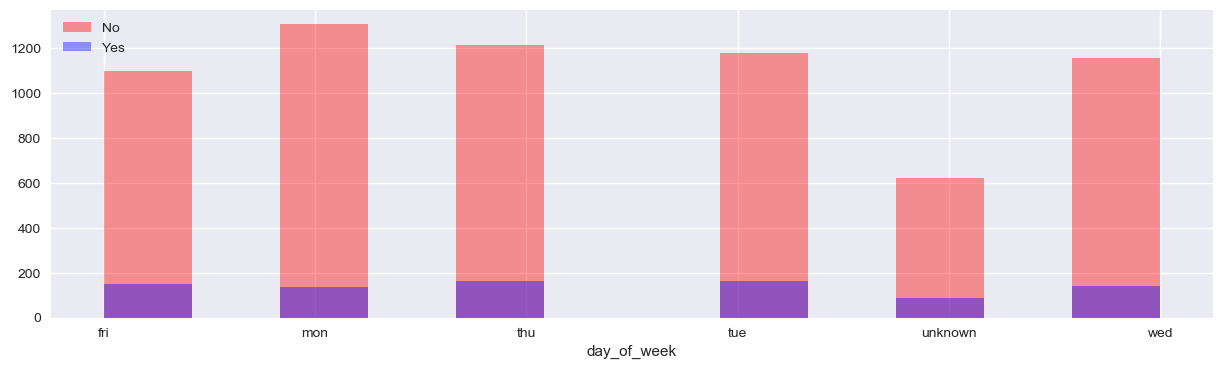

In [12]:
#day_of_week M C has 711 / 9.6% missing values 
dataColumn = 'day_of_week'

data[dataColumn]
display('Fill missing values with label "unknown"')
# sadly, we do not have more information about the missing values, could be weekends or any other week day
data[dataColumn].fillna('unknown', inplace=True)

counted = pd.DataFrame.from_dict(Counter(data[dataColumn]),orient='index')
counted.columns = [dataColumn]
display(pd.DataFrame(data[dataColumn].describe()).append(counted).T)

plot_histogram(data[dataColumn], data.responded)


### default

,count,unique,top,freq,unknown,no,yes
default,7414,3,no,5981,1432,5981,1


default ['no', 'unknown', 'yes']


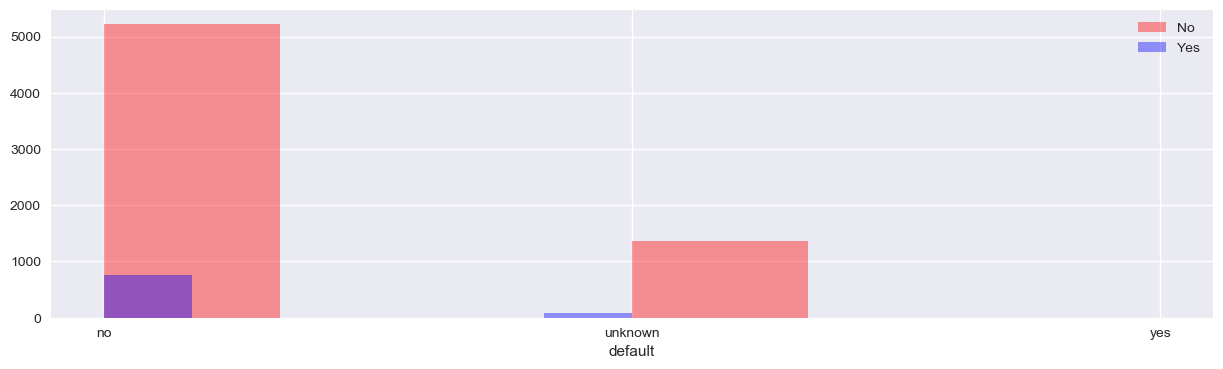

"how many 'yes' rows do we have?"

,campaign,cons.conf.idx,cons.price.idx,contact,custAge,day_of_week,default,emp.var.rate,euribor3m,housing,...,pastEmail,pdays,pmonths,poutcome,previous,profession,responded,schooling,campaign1,custAge1
798,2,-42.0,93.2,cellular,31.0,tue,yes,-0.1,4.153,no,...,0,999,999.0,failure,1,unemployed,no,high.school,2,31.0


"yes" record dropped
default ['no', 'unknown']


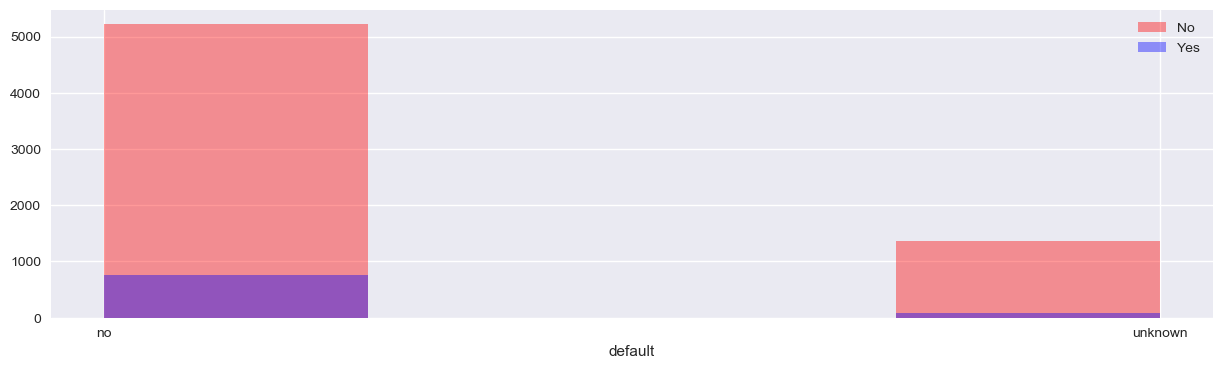

,count,unique,top,freq,unknown,no
default,7413,2,no,5981,1432,5981


In [13]:
#default C D

dataColumn = 'default'

counted = pd.DataFrame.from_dict(Counter(data[dataColumn]),orient='index')
counted.columns = [dataColumn]
display(pd.DataFrame(data[dataColumn].describe()).append(counted).T)

plot_histogram(data[dataColumn], data.responded)

display("how many 'yes' rows do we have?")
display(data[data[dataColumn] == 'yes'])
#there is only one record with yes, which we will drop
print('"yes" record dropped')
data = data[data[dataColumn] != 'yes']
plot_histogram(data[dataColumn], data.responded)

counted = pd.DataFrame.from_dict(Counter(data[dataColumn]),orient='index')
counted.columns = [dataColumn]
display(pd.DataFrame(data[dataColumn].describe()).append(counted).T)


### emp.var.rate, euribor3m, nr.employed

,count,mean,std,min,25%,50%,75%,max
emp.var.rate,7413.0,0.052111,1.568504,-3.400,-1.800,1.100,1.400,1.400
euribor3m,7413.0,3.583064,1.744970,0.634,1.334,4.857,4.961,5.045
nr.employed,7413.0,5165.220127,73.112738,4963.600,5099.100,5191.000,5228.100,5228.100


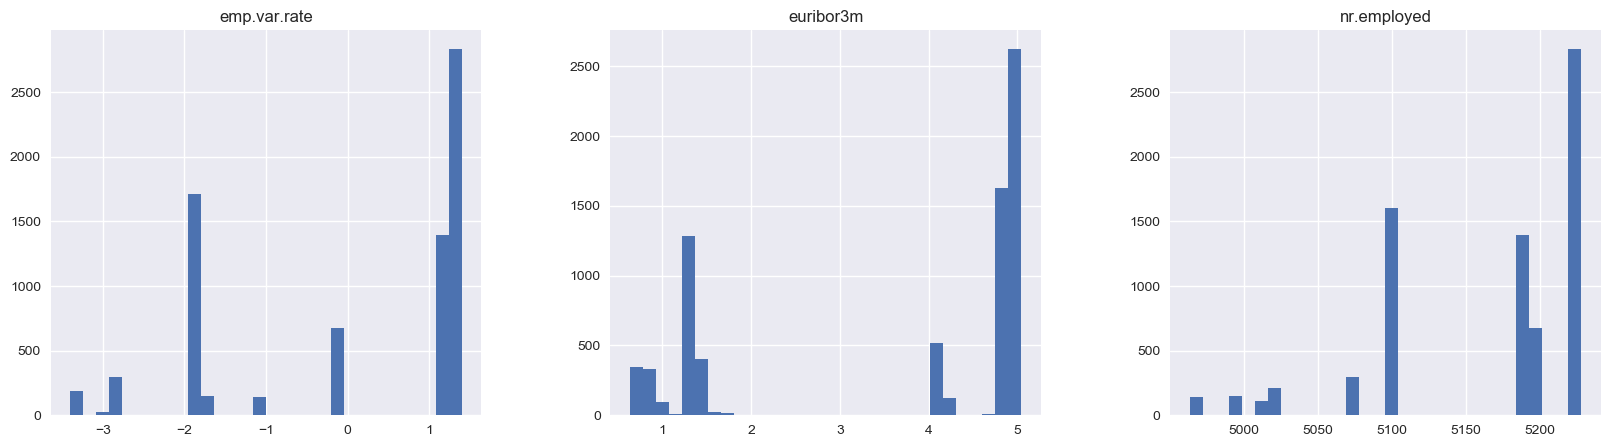

In [14]:
#euribor3m is highly correlated with emp.var.rate (ρ = 0.97095) and was Rejected by profiler
#nr.employed is highly correlated with euribor3m (ρ = 0.94255) and was Rejected by profiler
dataColumn = ["emp.var.rate", "euribor3m", 'nr.employed']

display(pd.DataFrame(data[dataColumn].describe()).T)

data[dataColumn].hist(figsize=(20, 5), layout=(1,3),bins=30)
plt.show()

### housing, loan, marital


housing ['no', 'unknown', 'yes']


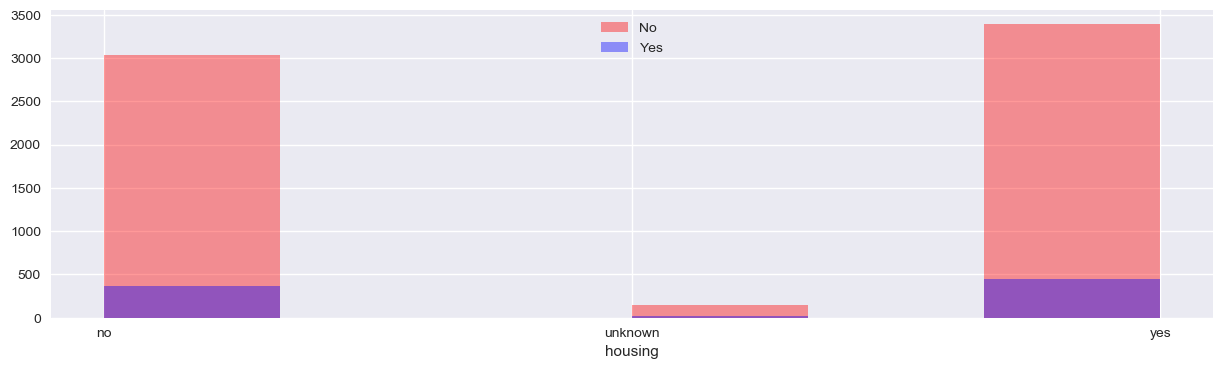

,count,unique,top,freq,no,yes,unknown
housing,7413,3,yes,3840,3405,3840,168


loan ['no', 'unknown', 'yes']


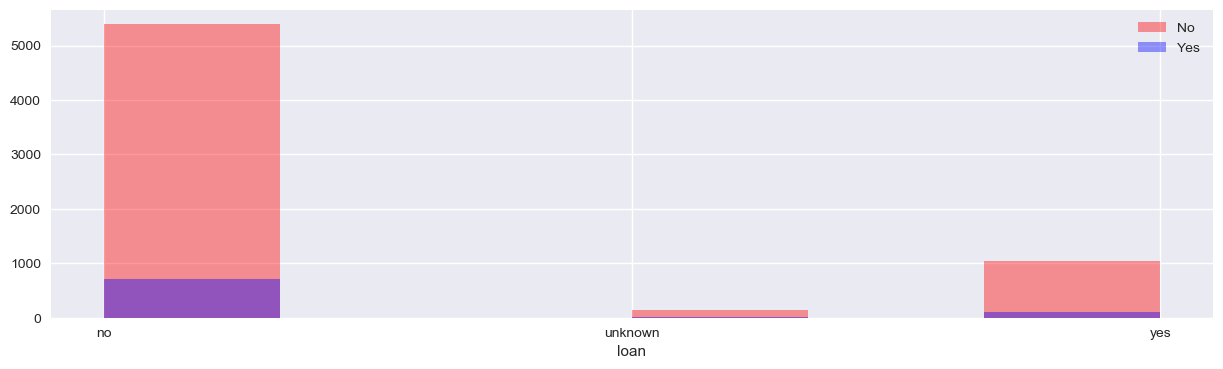

,count,unique,top,freq,no,yes,unknown
loan,7413,3,no,6098,6098,1147,168


marital ['divorced', 'married', 'single', 'unknown']


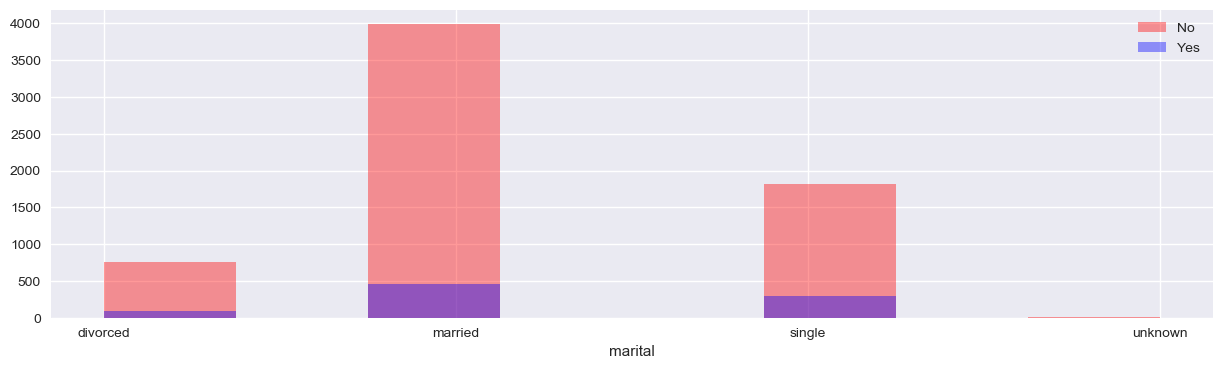

,count,unique,top,freq,single,married,divorced,unknown
marital,7413,4,married,4444,2118,4444,843,8


In [15]:
#housing, loan, marital, Month

dataColumn = ["housing", "loan", "marital"]

for column in dataColumn:
    plot_histogram(data[column], data.responded)

    counted = pd.DataFrame.from_dict(Counter(data[column]),orient='index')
    counted.columns = [column]
    display(pd.DataFrame(data[column].describe()).append(counted).T)


### month

month ['apr', 'aug', 'dec', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep']


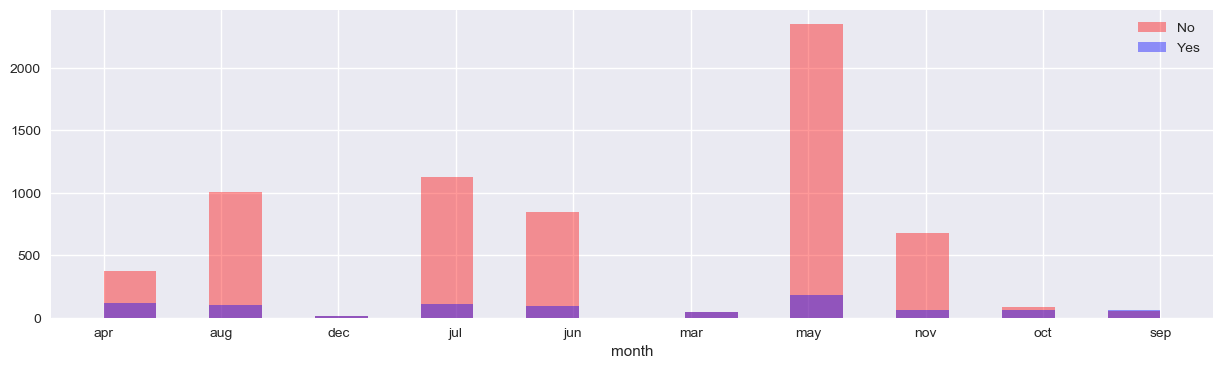

,count,unique,top,freq,nov,jul,may,aug,apr,jun,mar,oct,sep,dec
month,7413,10,may,2529,740,1229,2529,1112,487,939,93,145,112,27


In [16]:
# Month

dataColumn = "month"

plot_histogram(data[dataColumn], data.responded)

counted = pd.DataFrame.from_dict(Counter(data[dataColumn]),orient='index')
counted.columns = [dataColumn]
display(pd.DataFrame(data[dataColumn].describe()).append(counted).T)


### pastEmail 

,count,mean,std,min,25%,50%,75%,max
pastEmail,7413.0,0.361932,1.261747,0.0,0.0,0.0,0.0,18.0


pastEmail [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 18]


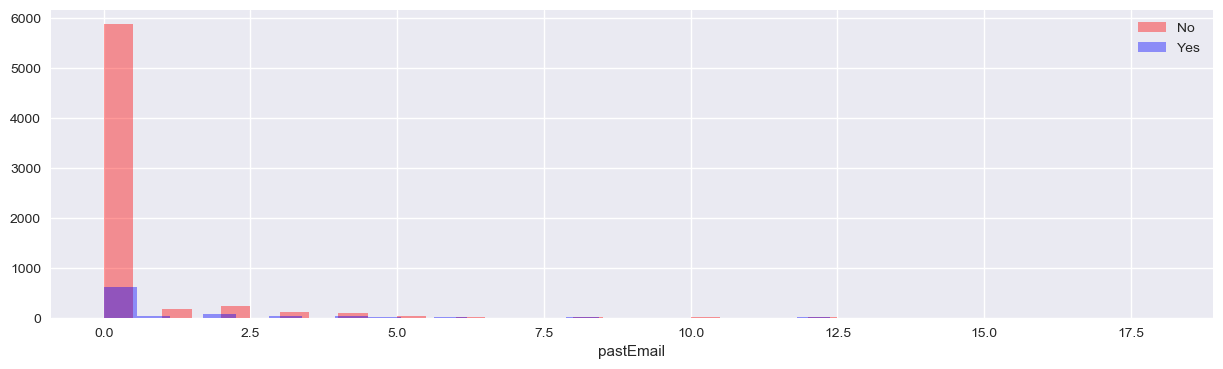

pastEmail [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 18]


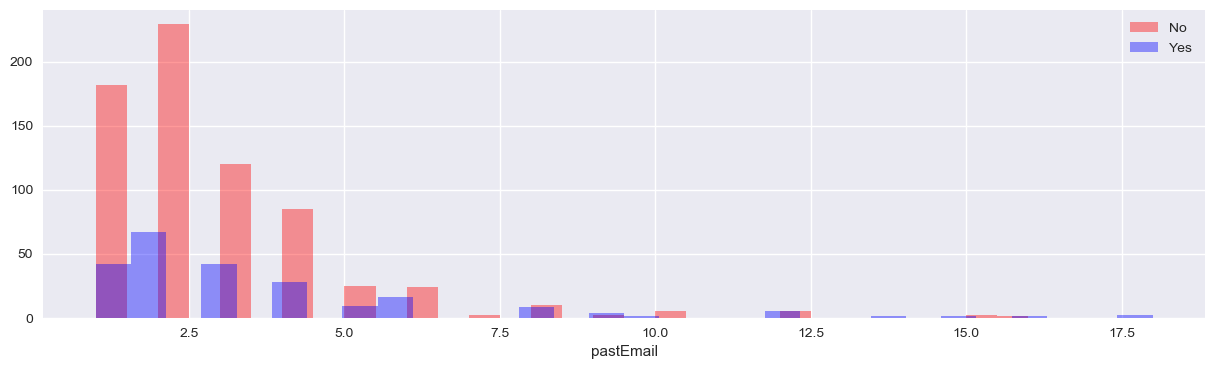

[-1.0, 7.0]

'Check outliers'

Outliers bounds: [0.0, 0.0]
Rename all ages higher than 0.0 as 1.0
pastEmail1 ['no', 'yes']


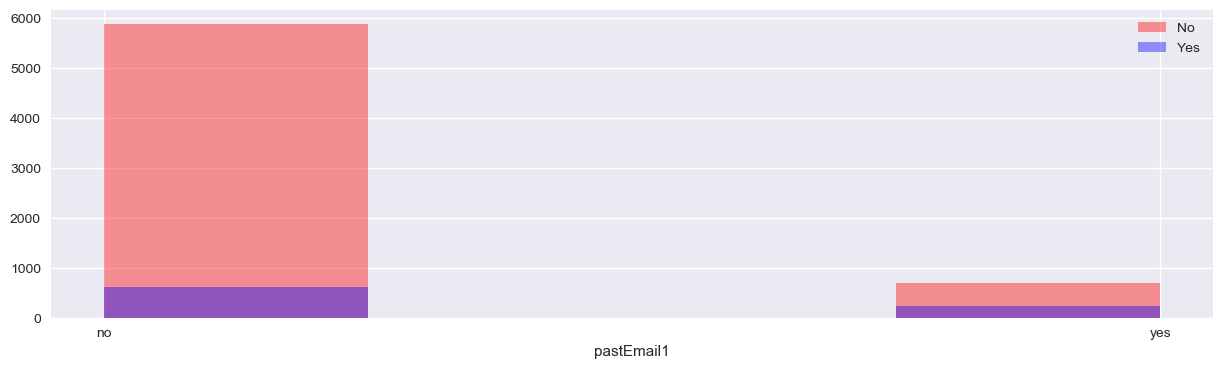

In [17]:
#pastEmail O has 6495 / 87.6% zeros
dataColumn = 'pastEmail'

display(pd.DataFrame(data[dataColumn].describe()).T)

plot_histogram(data[dataColumn], data.responded)

a = data[data[dataColumn]>0]
plot_histogram(a[dataColumn], a.responded)
display(get_outliers_bounds(a[dataColumn]))

#outliers
display('Check outliers')
outliers_bounds = get_outliers_bounds(data[dataColumn])
print('Outliers bounds:', outliers_bounds)

print('Rename all ages higher than',outliers_bounds[1], 'as', outliers_bounds[1]+1)

dataColumn = 'pastEmail1'

data[dataColumn] = data.pastEmail

data[dataColumn][data[dataColumn] > outliers_bounds[1]] = 'yes'
data[dataColumn][data[dataColumn] == 0] = 'no'

plot_histogram(data[dataColumn], data.responded)

### pdays, pmonths

,count,mean,std,min,25%,50%,75%,max
pdays,7413.0,960.01929,192.857506,0.0,999.0,999.0,999.0,999.0



yes, pdays and pmonths are very correlated with error: 2.2999999271799965e-07
pdays [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 999]


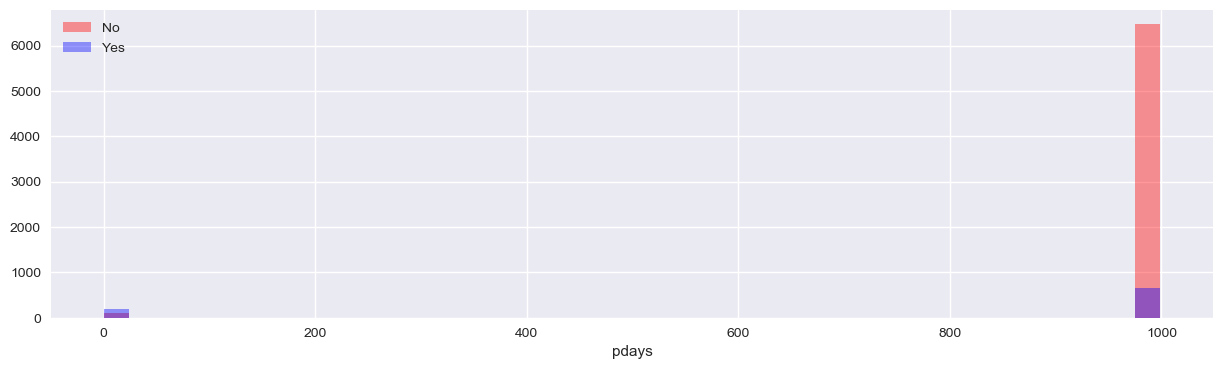

In [18]:
# pdays, pmonths 999? rest under 1 month
# pmonths is highly correlated with pdays (ρ = 0.99999) and was Rejected

dataColumn = 'pdays' 
display(pd.DataFrame(data[dataColumn].describe()).T)

#Are they really correlated?
days_months = data[data.pmonths<100][['pdays','pmonths']]

#small calculation to check errors by comparing both variables
print()
print('yes, pdays and pmonths are very correlated with error:', sum(days_months.pdays - days_months.pmonths*30))

plot_histogram(data[dataColumn], data.responded)

#too many 999s 96.1%!! rest under 1 month
data['pcontacted_pdays'] = data.pdays == 999   
#data.drop(['pdays','pmonths'], axis=1, inplace=True)
#print('pdays and pmonths have been dropped')


###  poutcome  and previous

,count,unique,top,freq,nonexistent,failure,success
poutcome,7413,3,nonexistent,6350,6350,799,264


poutcome ['failure', 'nonexistent', 'success']


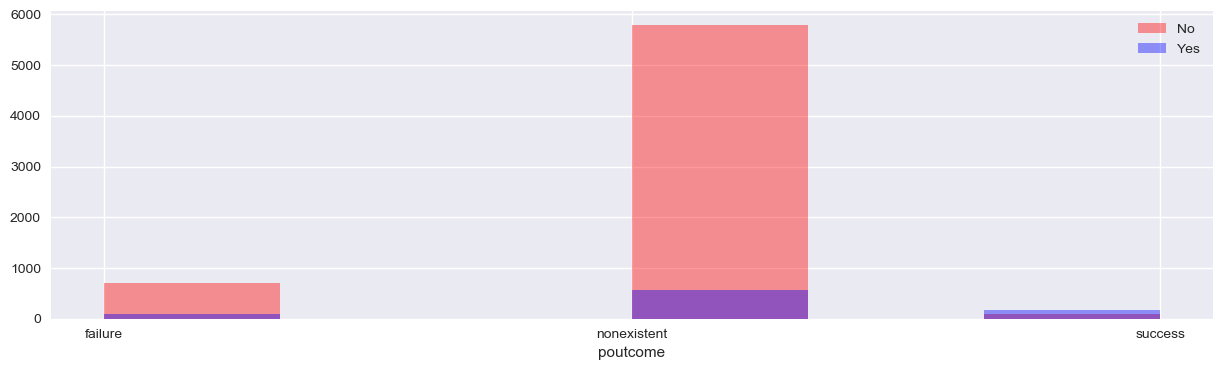

,count,mean,std,min,25%,50%,75%,max,0,1,2,4,3,5,6
previous,7413.0,0.184001,0.516723,0.0,0.0,0.0,0.0,6.0,6350.0,854.0,147.0,13.0,41.0,7.0,1.0


previous [0, 1, 2, 3, 4, 5, 6]


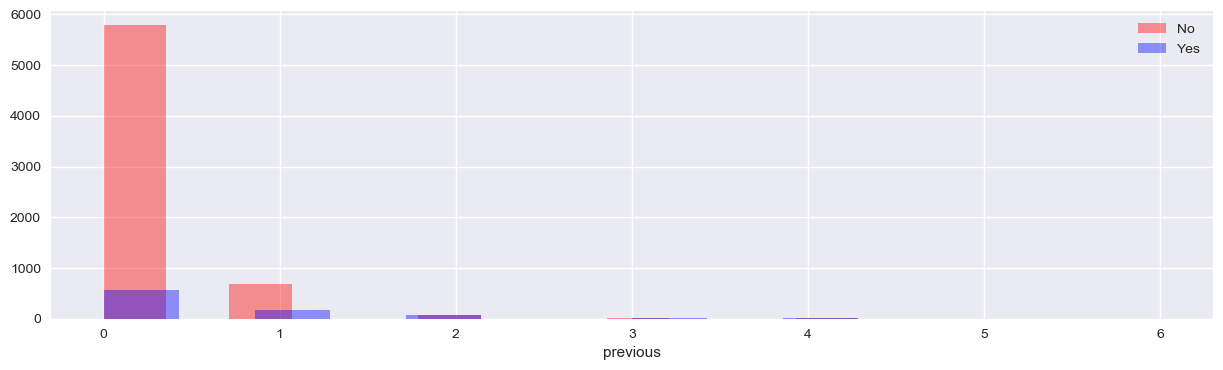

'Check outliers'

Outliers bounds: [0.0, 0.0]
Since there are many Zeros we will create another variable as pContacted_previous
Rename all previous higher than 0.0 as "yes" and 0 as "no"
pContacted_previous ['no', 'yes']


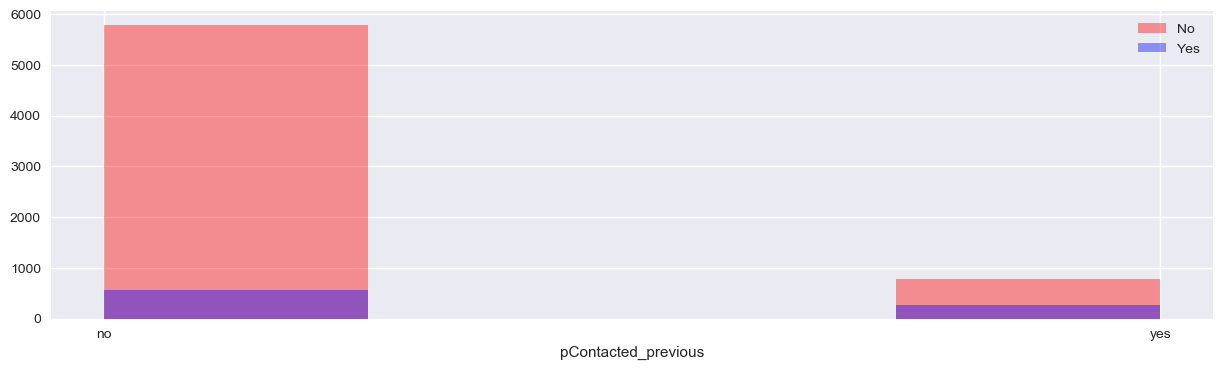

In [19]:
# poutcome 6350 and pdays has 999, 7123 times? 
# so, poutcome has 6350 nonexistent contacts, but there are 7123 that has never been contacted ?

# previous leave as is, has 6350 / 85.6% zeros
# ---as reminder--
# pdays: days that passed by after the applicant was last contacted, 
# previous: number of contacts 
# poutcome: outcome of the previous contact

dataColumn = ['poutcome', 'previous']

for column in dataColumn:
    counted = pd.DataFrame.from_dict(Counter(data[column]),orient='index')
    counted.columns = [column]
    display(pd.DataFrame(data[column].describe()).append(counted).T)
    
    plot_histogram(data[column], data.responded)

#-----now only previous

#outliers
display('Check outliers')
outliers_bounds = get_outliers_bounds(data[dataColumn[1]])
print('Outliers bounds:', outliers_bounds)

dataColumn = 'pContacted_previous'

print('Since there are many Zeros we will create another variable as', dataColumn)
print('Rename all previous higher than',outliers_bounds[1], 'as "yes" and 0 as "no"')

data[dataColumn] = data.previous
data[dataColumn][data[dataColumn] > outliers_bounds[1]] = 'yes'
data[dataColumn][data[dataColumn] == 0] = 'no'

plot_histogram(data[dataColumn], data.responded)


### profession

,admin.,blue-collar,technician,management,services,unemployed,housemaid,unknown,self-employed,retired,student,entrepreneur
profession,1885,1665,1212,536,719,172,187,61,248,307,146,275


,count,unique,top,freq
profession,7413,12,admin.,1885


profession ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown']


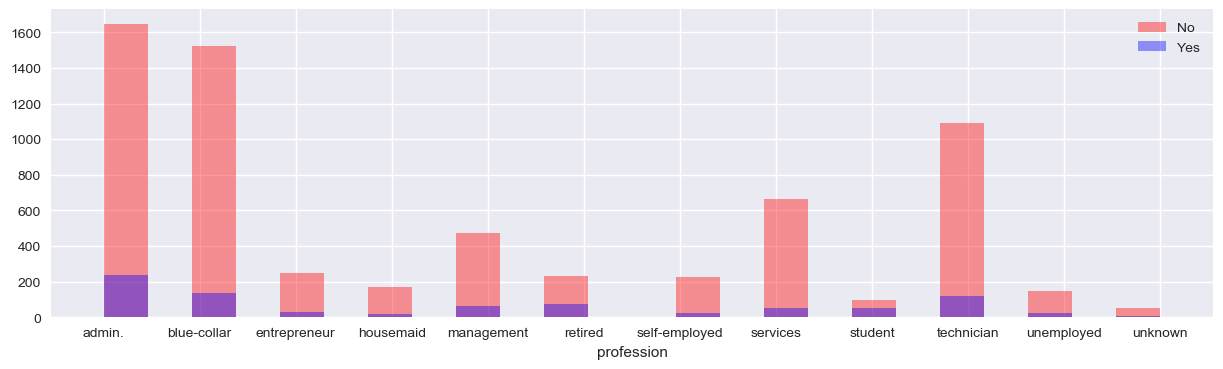

In [20]:
#profession C
dataColumn = 'profession'

#get counted values
counted = pd.DataFrame.from_dict(Counter(data[dataColumn]),orient='index')
counted.columns = [dataColumn]
display(counted.T)
display(pd.DataFrame(data[dataColumn].describe()).T)

plot_histogram(data[dataColumn], data.responded)

### schooling

'Fill missing values with label "other"'

,university.degree,other,high.school,basic.4y,basic.9y,professional.course,basic.6y
schooling,1554,2387,1215,534,784,664,275


,count,unique,top,freq
schooling,7413,7,other,2387


schooling ['basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'other', 'professional.course', 'university.degree']


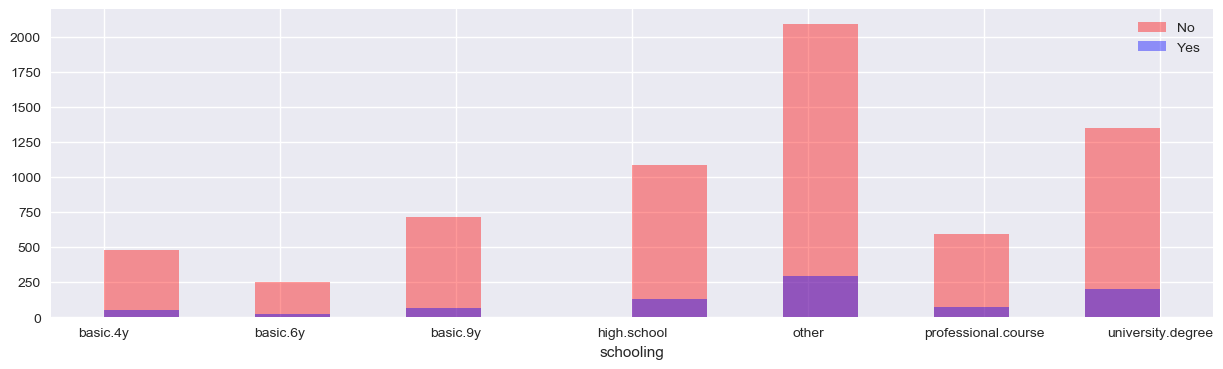

In [21]:
#schooling C D change missing to unknown has 2155 / 29.1% missing values 
dataColumn = 'schooling'

display('Fill missing values with label "other"')
data[dataColumn].fillna('other', inplace=True)
data[dataColumn].replace('illiterate','other', inplace=True)
data[dataColumn].replace('unknown','other', inplace=True)

counted = pd.DataFrame.from_dict(Counter(data[dataColumn]),orient='index')
counted.columns = [dataColumn]
display(counted.T)
display(pd.DataFrame(data[dataColumn].describe()).T)

plot_histogram(data[dataColumn], data.responded)


### remove duplicates records

In [22]:
print('previous shape', data.shape)
data.drop_duplicates(inplace=True)
print('new shape', data.shape)

previous shape (7413, 27)
new shape (7380, 27)


### Dropping columns used to create new ones

In [31]:
data.drop(['campaign', 'custAge', 'pastEmail', 'pmonths','pdays', 'previous'],axis=1, inplace=True)

,cons.conf.idx,cons.price.idx,contact,day_of_week,default,emp.var.rate,euribor3m,housing,loan,marital,...,nr.employed,poutcome,profession,responded,schooling,campaign1,custAge1,pastEmail1,pcontacted_pdays,pContacted_previous
0,-42.0,93.200,cellular,mon,unknown,-0.1,4.191,no,no,single,...,5195.8,nonexistent,admin.,no,university.degree,1,55.0,no,True,no
1,-42.7,93.918,cellular,mon,no,1.4,4.960,no,no,married,...,5228.1,nonexistent,blue-collar,no,other,1,42.0,no,True,no
2,-36.4,93.994,telephone,mon,no,1.1,4.857,no,no,married,...,5191.0,nonexistent,technician,no,high.school,1,42.0,no,True,no
3,-42.7,93.918,cellular,wed,unknown,1.4,4.962,yes,yes,divorced,...,5228.1,nonexistent,management,no,other,2,55.0,no,True,no
4,-46.2,92.893,cellular,tue,no,-1.8,1.291,yes,no,divorced,...,5099.1,failure,admin.,no,university.degree,5,45.0,yes,True,yes


## Save cleaned dataframe for future processing

In [32]:
data.to_csv(file_cleaned, sep=',', encoding='utf-8',index= False)